# Gauss-Levenberg-Marquardt (GLM) algorithm

The Gauss-Levenberg-Marquart (GLM) method is a derivative-based method used to search the objective function surface for its minimum value. It assumes that simulated values of observation targets vary continuously in response to changes in calibration-adjusted model parameters. 

However, certain combinations of parameters can provide similar fits to calibration data (as we saw in the "freyberg k and r" tutorial, in which we attempt to calibrate a model with two correlated parameters). This phenomenon is refered to as non-uniqueness. For a two-parameter case, this can be visualized as a "trough" in the objective function surface. In such cases, there is no single "minimum" value for the objective function. #dispair

Nevertheless, PEST(++) may obtain a solution to an ill-posed inverse problem and even fit the calibration dataset very well. This occurs due to the addition of the Marquardt lambda to the diagonal of the $J^{t}QJ$ matrix and enables the achievement of a set of parameters which minimize the objective function. However, this parameter set will not be unique. Changing observation weights, initial parameter values, or a different Marquardt lambda selection strategy, may result in an entirely different set of parameters which also minimize the objective function.

In practice, this can be avoided by ensuring a well-posed inverse problem. In simple terms, this requires having a greater number of sources of calibration data than the number of adjustable parameters. As we saw in the "freyberg k, r and flux observations" tutorial, one option is to include multiple types of observation data which inform different parameter types. (As we will see further on, regularisation provides another.)

In this tutorial we are going to visualize the "objective function surface" and how the parameter ugrade process moves across it. 

### Admin
We have provided some pre-cooked PEST dataset files, wrapped around the modified Freyberg model. This is the same dataset introduced in the "freyberg_pest_setup" and "freyberg_k" notebooks. 

The functions in the next cell import required dependencies and prepare a folder for you. This folder contains the model files and a preliminary PEST setup. Run the cells, then inspect the new folder named "freyberg_mf6" which has been created in your tutorial directory. (Just press `shift+enter` to run the cells). 

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import shutil

# sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd
import response_surface as resurf

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
tmp_d = os.path.join('freyberg_mf6')

runflag= True

if runflag==False:
    print('Assuming PEST++SWP has bene run already and the folder with files is available')
else:
    if os.path.exists(tmp_d):
        shutil.rmtree(tmp_d)
    shutil.copytree(org_d,tmp_d)
    # get executables
    hbd.prep_bins(tmp_d)
    # get dependency folders
    hbd.prep_deps(tmp_d)
    # run our convenience functions to prepare the PEST and model folder
    hbd.prep_pest(tmp_d)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the autho

### Reminder - the modified-Freyberg model
Just a quick reminder of what the model looks like and what we are doing. 

It is a one-layer model. A river runs north-south, represented with the SFR package (green cells in the figure). On the southern border there is a GHB (cyan cells). No-flow cells are shown in black. Pumping wells are shown with red cells. 

Time-series of measured heads are available at the locations marked with black X's. River flux is also measured at three locations (headwater, tailwater and gage; not displayed).

The simulation starts with a steady state stress period, followed by twelve transient stress periods. These represent the historic period, for which measured data are available.

A subsequent twelve transient stress periods representing a period in the future. Modelling is undertaken to assess selected forecasts during the simulated period.

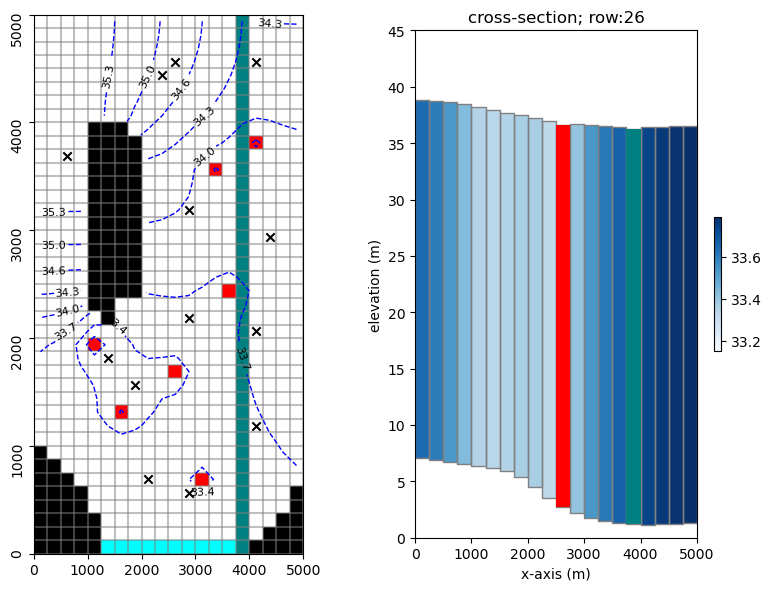

In [3]:
hbd.plot_freyberg(tmp_d)

### The PEST Control File

You may  wish to explore the `freyberg_mf6` folder which has been created in the tutorial directory. In it you will find a PEST control file named `freyberg.pst`.

Let's use `pyemu` to load the PEST control file and check some details. 

In [4]:
pst = pyemu.Pst(os.path.join(tmp_d, 'freyberg.pst'))
pst.par_names

['hk1', 'ne1', 'rch0', 'rch1']

In [5]:
par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,extra,dercom
parnme,,,,,,,,,,,
hk1,hk1,log,factor,5.00,0.050,500.00,hk,1.0,0.0,NaN,1.0
ne1,ne1,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,NaN,1.0
rch0,rch0,fixed,factor,1.00,0.500,2.00,rch0,1.0,0.0,NaN,1.0
rch1,rch1,fixed,factor,1.00,0.500,2.00,rch1,1.0,0.0,NaN,1.0


We shall explore the effect of having two adjustable parameters: `hk1` and `rch0`. As we saw previously, these two parameters are correlated. If we use only head observations for calibration we are unable to achive a unique solution. 

(We shall change `hk1` parameter bounds just to make visualization easier.)

In [6]:
par.loc['rch0', 'partrans'] = 'log'
par.loc['hk1', 'parlbnd'] = 1.5
par.loc['hk1', 'parubnd'] = 15

Re-write the control file:

In [7]:
pst.write(os.path.join(tmp_d, 'freyberg.pst'))

noptmax:0, npar_adj:2, nnz_obs:24


The `response_surface.py` file in the tutorial folder contains a few functions to run PEST++SWP and make plots. These run PEST++SWP a few hundred times for a combination of `hk1` and `rch0` values.

In [8]:
if runflag==False:
    print('Assuming PEST++SWP has bene run already and the folder with files is available')
else:
    resurf.run_respsurf(par_names=['hk1','rch0'])

noptmax:0, npar_adj:2, nnz_obs:24


             pestpp-swp - a parameteric sweep utility, version 5.2.6
                     for PEST(++) datasets 

                 by the PEST++ development team


...processing command line: ' ./pestpp-swp freyberg.pst /h :4004'
...using panther run manager in master mode using port 4004



version: 5.2.6
binary compiled on Aug 15 2023 at 16:48:53

started at 09/23/23 11:54:57
using control file: "freyberg.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_06_glm_response_surface/freyberg_mf6"
on host: "IGSACB116LHMNFI"

processing control file freyberg.pst
Note: 3 unused lines in pest control file, see rec file...
noptmax = 0, resetting max_run_fail = 1


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.           

Make a plot of the response surface for `hk1` (x-axis) and `rch0` (y-axis). The colored contours indicate the objective function value for each combination of these two parameters. 

As you can see, a long eliptical "trough of dispair" of optimal values is formed. Parameter combinations in this zone all result in equivalent levels of "good fit" to the observation dataset.  The trough of dispair is an example of non-uniqueness in graphically form.  A problem that arises is while many combinations of recharge and HK can fit the observation dataset, the forecasts of interest model with "calibrated" model could be highly sensitive to the value of HK and/or recharge and single "calibrated" model cant represent this non-uniqueness under forecasting conditions.  #uncertaintyanalysis

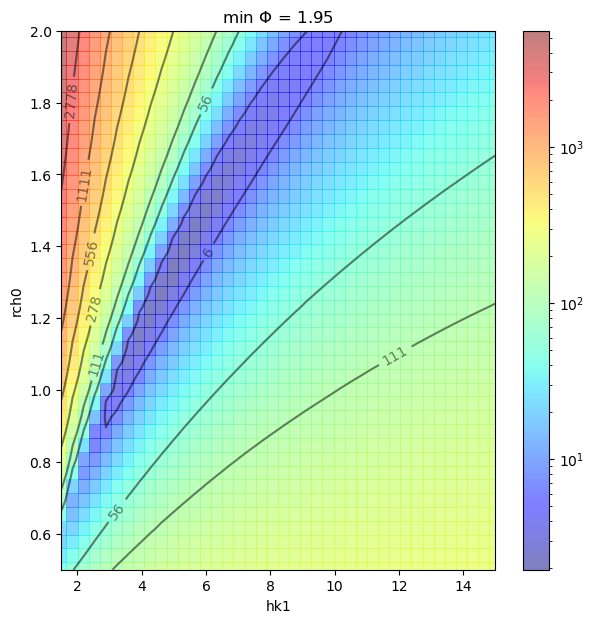

In [9]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7)) #maxresp=1e3,

### Add Flux Observations

As we did in the "freyberg k, r and flux obs" tutorial, we know add a second set of observation data. These are measurments of stream flow. We now have observations of head and observations of stream flow

In [10]:
pst = pyemu.Pst(os.path.join(tmp_d, 'freyberg.pst'))

In [11]:
# set weights to gage-1 observations during calibration period
obs = pst.observation_data
obs_times = obs.loc[~obs['gage-1'].isnull(), 'gage-1'].astype(float).values
calib_times = [str(i) for i in obs_times if i<4018.5]
obs.loc[obs['gage-1'].isin(calib_times), 'weight'] = 0.003

Re-write the control file.

In [12]:
pst.write(os.path.join(tmp_d, 'freyberg.pst'))

noptmax:0, npar_adj:2, nnz_obs:36


Run PEST++SWP again to recalcualte the response surface.

In [13]:
if runflag==False:
    print('Assuming PEST++SWP has been run already and the folder with files is available')
else:
    resurf.run_respsurf(par_names=['hk1','rch0'])

noptmax:0, npar_adj:2, nnz_obs:36


             pestpp-swp - a parameteric sweep utility, version 5.2.6
                     for PEST(++) datasets 

                 by the PEST++ development team


...processing command line: ' ./pestpp-swp freyberg.pst /h :4004'
...using panther run manager in master mode using port 4004



version: 5.2.6
binary compiled on Aug 15 2023 at 16:48:53

started at 09/23/23 12:01:56
using control file: "freyberg.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_06_glm_response_surface/freyberg_mf6"
on host: "IGSACB116LHMNFI"

processing control file freyberg.pst
Note: 3 unused lines in pest control file, see rec file...
noptmax = 0, resetting max_run_fail = 1


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.           

And plot it up again. Now we see the objective function surface funneling down to a single point. We have achieved a unique solution.  The "trough of dispair" has been the "bowl of uniqueness"!  A clear demonstration of the value of unique and diverse data...

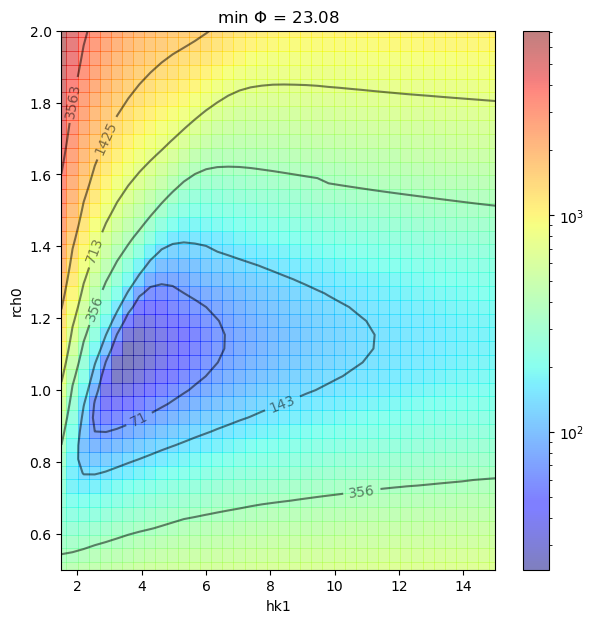

In [14]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7)) #maxresp=1e3,

# Understanding Lambdas

When used to undertake highly parameterized inversion, PESTPP-GLM implements theory and methodologies that are programmed into PEST. Some theory, employing matrices and vectors, is used to describe the linearized inverse problem on which so-called “gradient methods” are based. Through repeated linearization of the inverse problem over successive iterations, these methods achieve their purpose of model calibration, notwithstanding the nonlinear relationship that exists between model outputs and model parameters.  It should also be noted that PESTPP-IES also implements the GLM solution, but an ensemble of parameter vectors.  So the single trajectory below can be thought of as one of the many tradjectories that ensemble of parameter vectors take.

Nonlinear model behaviour is also accommodated by introducing a so-called "Marquardt lambda" to these equations. Employing a nonzero lambda tweaks the direction of parameter improvement so that it is more aligned with the objective function gradient. This increases the efficiency of early iterations of the inversion process when implemented in conjunction with a nonlinear model.

If Lambdas are high, then the parameter estimation process updates parameter values accodring to the objective function gradient. If they are small (or zero), parameter upgrades receive a greater influence from the $J^{t}QJ$ matrix. 

Highy non-linear problems, in particular, benefit from high lambdas at the start of the parameter estimation process. This accomodates non-elipticity of the objective function surface, avoiding sending the parameter estimation process in the "wrong direction" and wasting computation time. 

However, as the objective function minimum is approached, the process becomes more eficient if smaller lambdas are used. This avoids the phenomenon known as "hemstitching", in which parameter upgrades jump-across small, thin "troughs" in the objective function surface. 

Note again, the effect of lambda on the parameter upgrade is the same in PESTPP-IES.

See the PEST Book (Doherty, 2015) and the PEST++ users manual for more details.


### No Lambda

Let's visualize the effect of lambda values on the upgrade process. First, with no lambda added to the parameter upgrade equations.

In [15]:
# turn off the Maquardt lambda
pst.pestpp_options['lambdas']=0.0
pst.pestpp_options['lambda_scale_fac']=1.0
pst.pestpp_options['upgrade_augment']='False'

Initial parameter values specify where the parameter estimation process "starts":

In [16]:
# to make a more compeling plot
pst.parameter_data.loc['hk1', 'parval1'] = 14
pst.parameter_data.loc['rch0', 'parval1'] = 1.8

Write and run:

In [17]:
pst.control_data.noptmax=250
pst.write(os.path.join(tmp_d, 'freyberg.nolam.pst'))

if runflag==True:
    pyemu.os_utils.run('pestpp-glm freyberg.nolam.pst', cwd=tmp_d)

noptmax:250, npar_adj:2, nnz_obs:36


             pestpp-glm: a tool for GLM parameter estimation and FOSM uncertainty analysis

                                   by The PEST++ Development Team


version: 5.2.6
binary compiled on Aug 15 2023 at 16:48:53

started at 09/23/23 12:08:54
...processing command line: ' ./pestpp-glm freyberg.nolam.pst'
...using serial run manager

using control file: "freyberg.nolam.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_06_glm_response_surface/freyberg_mf6"
on host: "IGSACB116LHMNFI"

processing control file freyberg.nolam.pst
++UPGRADE_AUGMENT is deprecated and no longer supported...ignoring
Note: 3 unused lines in pest control file, see rec file...
checking model IO files...done
              starting serial run manager ...





OPTIMISATION ITERATION NUMBER: 1

  Iteration type: base parameter solution
  SVD Package: RedSVD
  Model calls so far : 0

  calculating jacobian... 



    ---  starting serial run man

Plot the response surface:

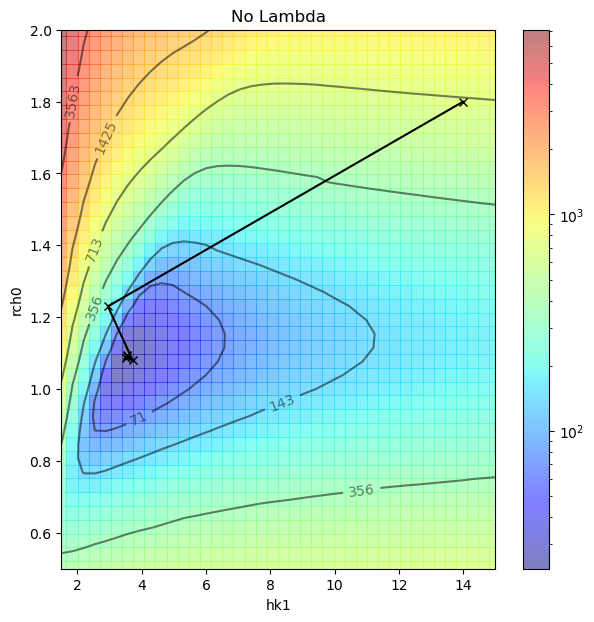

In [18]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7)) #maxresp=1e3,
pars, obfun = resurf.add_trajectory_to_plot(fig, ax, 'No Lambda', pst_name='freyberg.nolam.pst')

array([<Axes: xlabel='iteration'>, <Axes: xlabel='iteration'>],
      dtype=object)

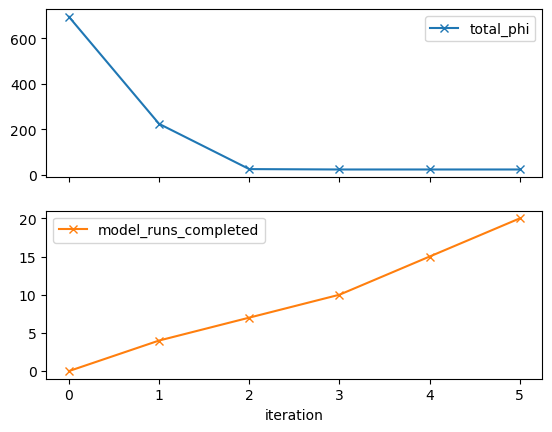

In [19]:
df_obj = pd.read_csv(os.path.join(tmp_d, "freyberg.nolam.iobj"), index_col=0)
df_obj.loc[:,["total_phi","model_runs_completed"]].plot(subplots=True, marker='x')

### Moderate Lambda

In [20]:
# set a moderate lambda value
pst.pestpp_options['lambdas']=700.0
pst.pestpp_options['lambda_scale_fac']=1.0
pst.pestpp_options['upgrade_augment']='False'

pst.write(os.path.join(tmp_d, 'freyberg.lam700.pst'))
if runflag==True:
    pyemu.os_utils.run('pestpp-glm freyberg.lam700.pst', cwd=tmp_d)

noptmax:250, npar_adj:2, nnz_obs:36


             pestpp-glm: a tool for GLM parameter estimation and FOSM uncertainty analysis

                                   by The PEST++ Development Team


version: 5.2.6
binary compiled on Aug 15 2023 at 16:48:53

started at 09/23/23 12:09:03
...processing command line: ' ./pestpp-glm freyberg.lam700.pst'
...using serial run manager

using control file: "freyberg.lam700.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_06_glm_response_surface/freyberg_mf6"
on host: "IGSACB116LHMNFI"

processing control file freyberg.lam700.pst
++UPGRADE_AUGMENT is deprecated and no longer supported...ignoring
Note: 3 unused lines in pest control file, see rec file...
checking model IO files...done
              starting serial run manager ...





OPTIMISATION ITERATION NUMBER: 1

  Iteration type: base parameter solution
  SVD Package: RedSVD
  Model calls so far : 0

  calculating jacobian... 



    ---  starting serial run 

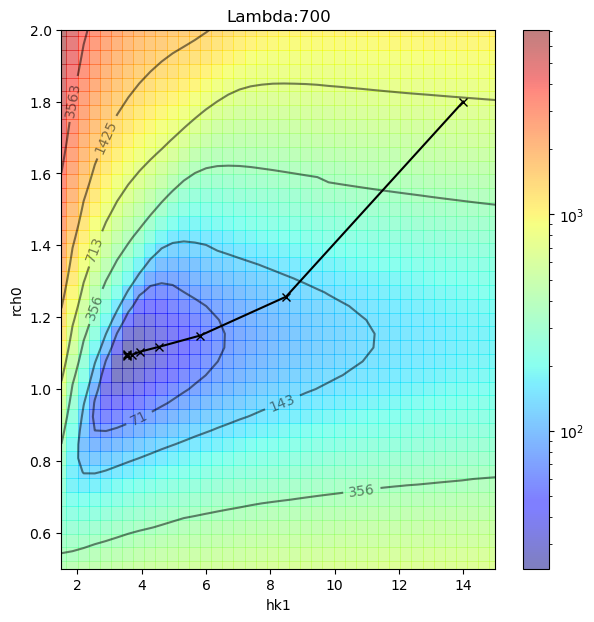

In [21]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7)) #maxresp=1e3,
pars, obfun = resurf.add_trajectory_to_plot(fig, ax, 'Lambda:700', pst_name='freyberg.lam700.pst')

array([<Axes: xlabel='iteration'>, <Axes: xlabel='iteration'>],
      dtype=object)

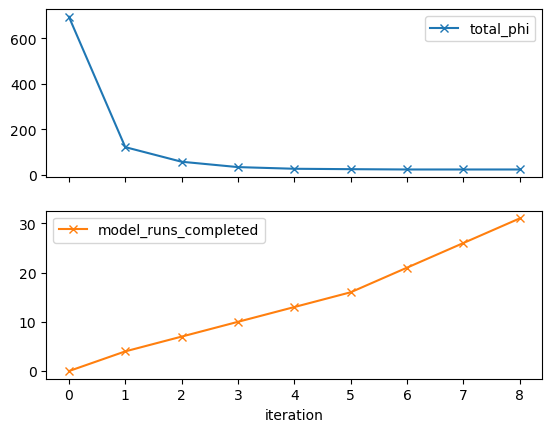

In [22]:
df_obj = pd.read_csv(os.path.join(tmp_d, "freyberg.lam700.iobj"), index_col=0)
df_obj.loc[:,["total_phi","model_runs_completed"]].plot(subplots=True, marker='x')

### Large Lambda

In [23]:
# set a large lambda value
pst.pestpp_options['lambdas']=7000.0
pst.pestpp_options['lambda_scale_fac']=1.0
pst.pestpp_options['upgrade_augment']='False'

pst.write(os.path.join(tmp_d, 'freyberg.lam7000.pst'))
if runflag==True:
    pyemu.os_utils.run('pestpp-glm freyberg.lam7000.pst', cwd=tmp_d)

noptmax:250, npar_adj:2, nnz_obs:36


             pestpp-glm: a tool for GLM parameter estimation and FOSM uncertainty analysis

                                   by The PEST++ Development Team


version: 5.2.6
binary compiled on Aug 15 2023 at 16:48:53

started at 09/23/23 12:09:16
...processing command line: ' ./pestpp-glm freyberg.lam7000.pst'
...using serial run manager

using control file: "freyberg.lam7000.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_06_glm_response_surface/freyberg_mf6"
on host: "IGSACB116LHMNFI"

processing control file freyberg.lam7000.pst
++UPGRADE_AUGMENT is deprecated and no longer supported...ignoring
Note: 3 unused lines in pest control file, see rec file...
checking model IO files...done
              starting serial run manager ...





OPTIMISATION ITERATION NUMBER: 1

  Iteration type: base parameter solution
  SVD Package: RedSVD
  Model calls so far : 0

  calculating jacobian... 



    ---  starting serial r

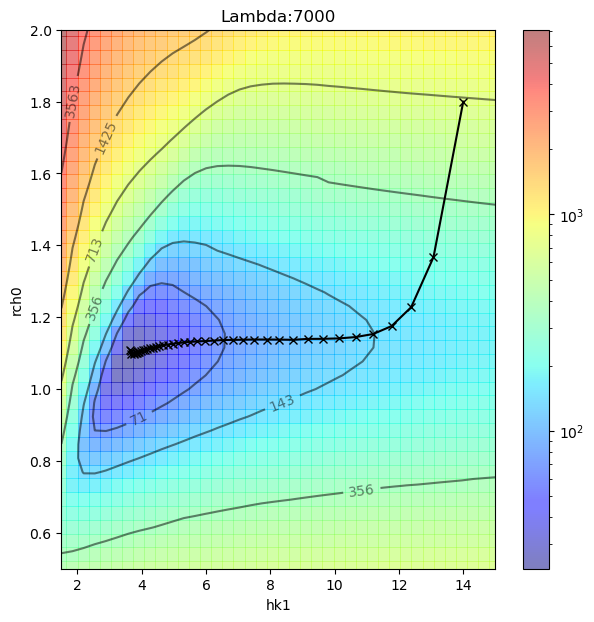

In [24]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7)) #maxresp=1e3,
pars, obfun = resurf.add_trajectory_to_plot(fig, ax, 'Lambda:7000', pst_name='freyberg.lam7000.pst')

array([<Axes: xlabel='iteration'>, <Axes: xlabel='iteration'>],
      dtype=object)

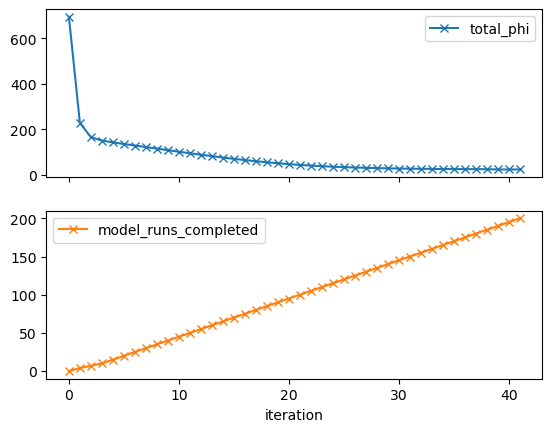

In [25]:
df_obj = pd.read_csv(os.path.join(tmp_d, "freyberg.lam7000.iobj"), index_col=0)
df_obj.loc[:,["total_phi","model_runs_completed"]].plot(subplots=True, marker='x')

### Normal PEST(++) Behaviour

In practice, PEST and PEST++ can search for the optimal parameter upgrade vector at each iteration. PEST(++) calculates upgrade vectors, each based on a different value of lambda. The one which results in the largest objective function decrease is used to calculate parameters for the next iteration. 

In [26]:
# turn off the Maquardt lambda
pst.pestpp_options['lambdas']= [0.1, 1, 10,100]
pst.pestpp_options['lambda_scale_fac']=[0.9, 0.8, 0.7, 0.5]
pst.pestpp_options['upgrade_augment']='True'

pst.write(os.path.join(tmp_d, 'freyberg.pst'))
if runflag==True:
    pyemu.os_utils.run('pestpp-glm freyberg.pst', cwd=tmp_d)

noptmax:250, npar_adj:2, nnz_obs:36


             pestpp-glm: a tool for GLM parameter estimation and FOSM uncertainty analysis

                                   by The PEST++ Development Team


version: 5.2.6
binary compiled on Aug 15 2023 at 16:48:53

started at 09/23/23 12:10:40
...processing command line: ' ./pestpp-glm freyberg.pst'
...using serial run manager

using control file: "freyberg.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_06_glm_response_surface/freyberg_mf6"
on host: "IGSACB116LHMNFI"

processing control file freyberg.pst
++UPGRADE_AUGMENT is deprecated and no longer supported...ignoring
Note: 3 unused lines in pest control file, see rec file...
checking model IO files...done
              starting serial run manager ...





OPTIMISATION ITERATION NUMBER: 1

  Iteration type: base parameter solution
  SVD Package: RedSVD
  Model calls so far : 0

  calculating jacobian... 



    ---  starting serial run manager for 3 runs --

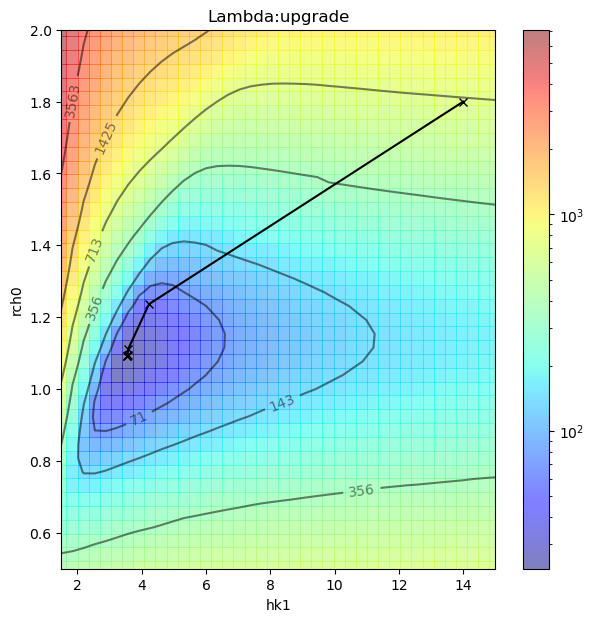

In [27]:
fig, ax, resp_surf = resurf.plot_response_surface(cmap='jet', figsize=(7,7)) #maxresp=1e3,
pars, obfun = resurf.add_trajectory_to_plot(fig, ax, 'Lambda:upgrade', pst_name='freyberg.pst')

array([<Axes: xlabel='iteration'>, <Axes: xlabel='iteration'>],
      dtype=object)

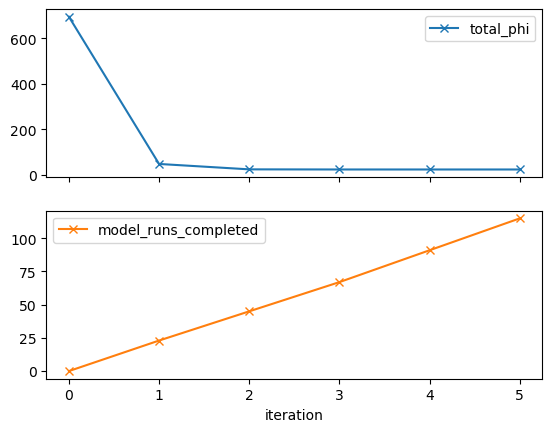

In [28]:
df_obj = pd.read_csv(os.path.join(tmp_d, "freyberg.iobj"), index_col=0)
df_obj.loc[:,["total_phi","model_runs_completed"]].plot(subplots=True, marker='x')